In [1]:
%matplotlib inline

import cv2, json, os
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm

from custom_utils import evaluation_metric
from custom_utils.plate_detector import Plate_Detector
from custom_utils.coner_detector import Corner_Detector
from custom_utils.plate_type_classifier import Plate_Type_Classifier
from custom_utils.synthetic_plate_generator import Synthetic_Plate_Generator
from custom_utils.pix2pix import Synthetic_Plate_Generator_pix2pix
from custom_utils.plate_synthesizer import Plate_Synthesizer

yolo_detector             = Plate_Detector(device='cuda:0', margin_gain=0.45)
corner_detector           = Corner_Detector(device='cuda')
plate_type_classifier     = Plate_Type_Classifier(device='cuda')
# synthetic_plate_generator = Synthetic_Plate_Generator(device='cuda')
# synthetic_plate_generator = Synthetic_Plate_Generator_nueral(device='cuda')
synthetic_plate_generator = Synthetic_Plate_Generator_pix2pix(device='cuda')
plate_synthesizer         = Plate_Synthesizer()

generater_type = synthetic_plate_generator.name

c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5  2023-10-3 Python-3.8.16 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs


initialize network with normal



### Bbox 정답 xy 좌표 추출

In [2]:
json_path = './Labels/total.json'
bboxes_xy_label = defaultdict(int)

with open(json_path, 'r') as f:
    json_data = json.load(f)
    
for key in tqdm(list(json_data.keys())):
    
    img_name = json_data[key]['filename'].split('.')[0]
    
    # label
    bbox_regions = json_data[key]['regions']
    labels = []

    for bbox_attr in bbox_regions:
        x1 = bbox_attr['shape_attributes']['x']
        y1 = bbox_attr['shape_attributes']['y']
        x2 = x1 + bbox_attr['shape_attributes']['width']
        y2 = y1 + bbox_attr['shape_attributes']['height']
        labels.append([x1, y1, x2, y2])
    bboxes_xy_label[img_name] = labels
    

100%|██████████| 326/326 [00:00<00:00, 325016.19it/s]


### 평가

In [3]:
file_names = os.listdir('./raw_images/')

TP, FP, FN = 0, 0, 0
brisque_origin_score = []
brisque_syn_score    = []

psnr_syn_score = []
psnr_mask_score = []
psnr_blur_score = []

ssim_syn_score = []
ssim_mask_score = []
ssim_blur_score = []

for file_name in tqdm(file_names):
    im = cv2.imread('./raw_images/{}'.format(file_name))
    bboxes , bboxes_xy = yolo_detector.predict(im)
    
    bboxes_xy_pred = []
    for bboxes_xy_i in bboxes_xy: # yyxx format
        bboxes_xy_pred.append([bboxes_xy_i[2], bboxes_xy_i[0], bboxes_xy_i[3], bboxes_xy_i[1]])
    
    # TF인 부분만 고려
    bboxes_TF = []
    for bboxes_xy_i in bboxes_xy:
        bboxes_TF.append(evaluation_metric.check_TP(bboxes_xy_i, bboxes_xy_label[file_name.split('.')[0]]))
    
    TP_i, FP_i, FN_i, Confusion_matrix = evaluation_metric.f1_score(bboxes_xy_pred, bboxes_xy_label[file_name.split('.')[0]])
    
    TP += TP_i
    FP += FP_i
    FN += FN_i
    
    xy_list = corner_detector.predict(bboxes)
    plate_type_list = plate_type_classifier.predict(bboxes, xy_list)
    synthetic_plate_list = synthetic_plate_generator.predict(bboxes, xy_list, plate_type_list)
    result_im = plate_synthesizer.predict(im, xy_list, bboxes, bboxes_xy, synthetic_plate_list, generater_type);
    
    cv2.imwrite('./generate_images/{}/{}'.format(generater_type+'_v5', file_name), result_im)
    
    for bboxes_xy_i, state in zip(bboxes_xy, bboxes_TF):
        y1, y2, x1, x2 = bboxes_xy_i[0], bboxes_xy_i[1], bboxes_xy_i[2], bboxes_xy_i[3]
        origin_im = im[y1:y2, x1:x2, :].copy()
        syn_im    = result_im[y1:y2, x1:x2, :].copy()
        
        #### masking, blurring
        
        ## masking
        not_weight_plate_h = (y2-y1) * 0.45
        not_weight_plate_w = (x2-x1) * 0.45
        
        y1_ = y1 + int(not_weight_plate_h//2)
        y2_ = y2 - int(not_weight_plate_h//2)
        x1_ = x1 + int(not_weight_plate_w//2)
        x2_ = x2 - int(not_weight_plate_w//2)
        
        tmp = im.copy()
        for i in range(3): # zero masking
            tmp[y1_:y2_, x1_:x2_, i] = 255
        masking_img = tmp[y1:y2, x1:x2, :].copy()
        
        ## blurring
        kernel_size = (0, 0)
        kernel_sigma = 10
        
        tmp = im.copy()
        tmp[y1_:y2_, x1_:x2_, :] = cv2.GaussianBlur(tmp[y1_:y2_, x1_:x2_, :], kernel_size, kernel_sigma)
        blurring_img = tmp[y1:y2, x1:x2, :].copy()
        
        ####
        
        # TF인 부분만 고려
        if state:
            brisque_origin_score.append(evaluation_metric.brisque_score(origin_im))
            brisque_syn_score.append(evaluation_metric.brisque_score(syn_im))
            psnr_syn_score.append(evaluation_metric.psnr_score(origin_im, syn_im))
            ssim_syn_score.append(evaluation_metric.ssim_score(origin_im, syn_im))
            
            psnr_mask_score.append(evaluation_metric.psnr_score(origin_im, masking_img))
            ssim_mask_score.append(evaluation_metric.ssim_score(origin_im, masking_img))
            
            psnr_blur_score.append(evaluation_metric.psnr_score(origin_im, blurring_img))
            ssim_blur_score.append(evaluation_metric.ssim_score(origin_im, blurring_img))

100%|██████████| 324/324 [06:24<00:00,  1.19s/it]


In [4]:
Precision = TP/(TP+FP)
Recall    = TP/(TP+FN)
F1_score   = 2*(Precision*Recall)/(Precision+Recall)

In [5]:
import pandas as pd

In [6]:
score_df = pd.DataFrame({'brisque_origin_score':brisque_origin_score,
                         'brisque_syn_score':brisque_syn_score,
                         'psnr_syn_score':psnr_syn_score,
                         
                         'psnr_mask_score':psnr_mask_score,
                         'psnr_blur_score':psnr_blur_score,
                         
                         'ssim_syn_score':ssim_syn_score,
                         'ssim_mask_score':ssim_mask_score,
                         'ssim_blur_score':ssim_blur_score,
                         
                         'Precision' : Precision,
                         'Recall' : Recall,
                         'F1_score' : F1_score,
                         'time' : '7m18s'
                        })

In [7]:
score_df.to_csv('pix2pixv5_result.csv', header=True)

In [2]:
import pandas as pd

In [7]:
pidx2pix_df         = pd.read_csv('./pix2pixv5_result.csv', index_col = 0)
styleswap_df        = pd.read_csv('./style_swap_result.csv', index_col = 0)
styletransfer_df    = pd.read_csv('./neural_style_transfer_result.csv', index_col = 0)

In [8]:
score_df = pidx2pix_df
print('---------------BRISQUE--------------- 작을 수록 좋음')
print("원본 이미지 BRISQUE SCORE : ", score_df['brisque_origin_score'].mean())
print("합성 이미지 BRISQUE SCORE : ", score_df['brisque_syn_score'].mean())
print('\n')

print('---------------PSNR--------------- 클수록 좋음')
print("합성     이미지 PSNR SCORE : ", score_df['psnr_syn_score'].mean())
print("마스크   이미지 PSNR SCORE : ", score_df['psnr_mask_score'].mean())
print("블러     이미지 PSNR SCORE : ", score_df['psnr_blur_score'].mean())
print('\n')

print('---------------SSIM--------------- 1에 가까울수록 좋음')
print("합성     이미지 SSIM SCORE : ", score_df['ssim_syn_score'].mean())
print("마스크   이미지 SSIM SCORE : ", score_df['ssim_mask_score'].mean())
print("블러     이미지 SSIM SCORE : ", score_df['ssim_blur_score'].mean())

---------------BRISQUE--------------- 작을 수록 좋음
원본 이미지 BRISQUE SCORE :  24.76281930031432
합성 이미지 BRISQUE SCORE :  45.519925626424936


---------------PSNR--------------- 클수록 좋음
합성     이미지 PSNR SCORE :  21.14035797948308
마스크   이미지 PSNR SCORE :  9.542633759124016
블러     이미지 PSNR SCORE :  20.59396039664028


---------------SSIM--------------- 1에 가까울수록 좋음
합성     이미지 SSIM SCORE :  0.7905482010386436
마스크   이미지 SSIM SCORE :  0.6560032367602053
블러     이미지 SSIM SCORE :  0.7269054813893352


In [9]:
score_df = styleswap_df
print('---------------BRISQUE--------------- 작을 수록 좋음')
print("원본 이미지 BRISQUE SCORE : ", score_df['brisque_origin_score'].mean())
print("합성 이미지 BRISQUE SCORE : ", score_df['brisque_syn_score'].mean())
print('\n')

print('---------------PSNR--------------- 클수록 좋음')
print("합성     이미지 PSNR SCORE : ", score_df['psnr_syn_score'].mean())
print("마스크   이미지 PSNR SCORE : ", score_df['psnr_mask_score'].mean())
print("블러     이미지 PSNR SCORE : ", score_df['psnr_blur_score'].mean())
print('\n')

print('---------------SSIM--------------- 1에 가까울수록 좋음')
print("합성     이미지 SSIM SCORE : ", score_df['ssim_syn_score'].mean())
print("마스크   이미지 SSIM SCORE : ", score_df['ssim_mask_score'].mean())
print("블러     이미지 SSIM SCORE : ", score_df['ssim_blur_score'].mean())

---------------BRISQUE--------------- 작을 수록 좋음
원본 이미지 BRISQUE SCORE :  24.76281930031432
합성 이미지 BRISQUE SCORE :  43.32730948796636


---------------PSNR--------------- 클수록 좋음
합성     이미지 PSNR SCORE :  21.967346654148447
마스크   이미지 PSNR SCORE :  9.542633759124016
블러     이미지 PSNR SCORE :  20.59396039664028


---------------SSIM--------------- 1에 가까울수록 좋음
합성     이미지 SSIM SCORE :  0.8353776365557939
마스크   이미지 SSIM SCORE :  0.6560032367602053
블러     이미지 SSIM SCORE :  0.7269054813893352


In [10]:
score_df = styletransfer_df
print('---------------BRISQUE--------------- 작을 수록 좋음')
print("원본 이미지 BRISQUE SCORE : ", score_df['brisque_origin_score'].mean())
print("합성 이미지 BRISQUE SCORE : ", score_df['brisque_syn_score'].mean())
print('\n')

print('---------------PSNR--------------- 클수록 좋음')
print("합성     이미지 PSNR SCORE : ", score_df['psnr_syn_score'].mean())
print("마스크   이미지 PSNR SCORE : ", score_df['psnr_mask_score'].mean())
print("블러     이미지 PSNR SCORE : ", score_df['psnr_blur_score'].mean())
print('\n')

print('---------------SSIM--------------- 1에 가까울수록 좋음')
print("합성     이미지 SSIM SCORE : ", score_df['ssim_syn_score'].mean())
print("마스크   이미지 SSIM SCORE : ", score_df['ssim_mask_score'].mean())
print("블러     이미지 SSIM SCORE : ", score_df['ssim_blur_score'].mean())

---------------BRISQUE--------------- 작을 수록 좋음
원본 이미지 BRISQUE SCORE :  24.746121466951905
합성 이미지 BRISQUE SCORE :  42.96687468907988


---------------PSNR--------------- 클수록 좋음
합성     이미지 PSNR SCORE :  21.562806408064084
마스크   이미지 PSNR SCORE :  9.541682839527454
블러     이미지 PSNR SCORE :  20.59401537400496


---------------SSIM--------------- 1에 가까울수록 좋음
합성     이미지 SSIM SCORE :  0.8339915355993023
마스크   이미지 SSIM SCORE :  0.6559702638166045
블러     이미지 SSIM SCORE :  0.7268984374904154


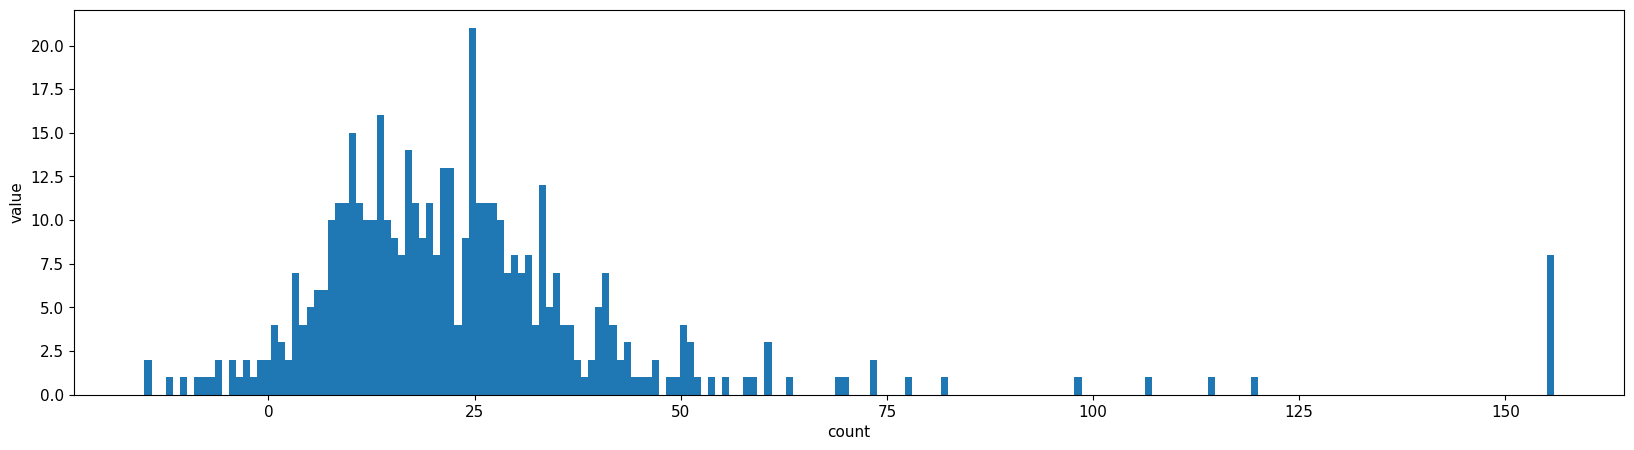

In [26]:
%matplotlib inline
briq_origina_score = score_df[['brisque_origin_score']].values
fig = plt.figure(figsize=(20, 5))
plt.hist(briq_origina_score, bins=200)
plt.xlabel('count')
plt.ylabel('value')
plt.show()


In [ ]:
# https://openaccess.thecvf.com/content_CVPRW_2019/papers/CV-COPS/Li_AnonymousNet_Natural_Face_De-Identification_With_Measurable_Privacy_CVPRW_2019_paper.pdf